In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
%matplotlib inline
import gc
import os
from skimage import io


dirname = '20200812/'

xyname = 'xyt_colocalization.npz'
#neighborname = 'neighbor_colocalization100.npy'

path_xy = '/home/uwamichi/work/dicty_cell_sort/hashimura/{}{}'.format(dirname, xyname)
#path_neighbor = '/content/drive/MyDrive/Colab Notebooks/data/DictySort/{}{}'.format(dirname, neighborname)


trajList = np.load(path_xy, allow_pickle=True)
print(trajList.files)

#ind_neighbors_full = np.load(path_neighbor, allow_pickle=True)
#print(ind_neighbors_full)

['x', 'y', 'types', 'xyscale', 'Tmax', 'N', 'periodic']


In [201]:
dirname_auto = '20200812/track_220711/res10_1/'
xyname_auto = 'track.npz'

path_auto = '/home/uwamichi/work/dicty_cell_sort/hashimura/{}{}'.format(dirname_auto, xyname_auto)
#path_neighbor = '/content/drive/MyDrive/Colab Notebooks/data/DictySort/{}{}'.format(dirname, neighborname)

path_im = '/home/uwamichi/work/dicty_cell_sort/hashimura/20200812/im2/'

path_figsave0 = '/home/uwamichi/work/dicty_cell_sort/hashimura/{}{}'.format(dirname_auto, 'graph/')
os.makedirs(path_figsave0, exist_ok=True)

path_figsave = path_figsave0 + 'im2track_largeDeviation/'
os.makedirs(path_figsave, exist_ok=True)

path_figsave2 = path_figsave0 + 'im2track_match/'
os.makedirs(path_figsave2, exist_ok=True)


trajList_auto = np.load(path_auto, allow_pickle=True)
print(trajList_auto.files)

['x', 'y', 'theta', 'majorR', 'minorR', 'M', 'bounds']


In [202]:
DELAY_DIV = 3
xyscale = 0.226 #[um/pix]
dt = 10 # [sec]

d_delay = DELAY_DIV * dt

N_particles = trajList['x'].shape[0]
N_particles_auto = trajList_auto['x'].shape[0]


calculate velocity

In [203]:
vx = (trajList['x'][:, DELAY_DIV:] - trajList['x'][:, :-DELAY_DIV]) / d_delay
vy = (trajList['y'][:, DELAY_DIV:] - trajList['y'][:, :-DELAY_DIV]) / d_delay

In [204]:
vx_auto = (trajList_auto['x'][DELAY_DIV:] - trajList_auto['x'][:-DELAY_DIV]).T * (xyscale / d_delay)
vy_auto = (trajList_auto['y'][DELAY_DIV:] - trajList_auto['y'][:-DELAY_DIV]).T * (xyscale / d_delay)

match datapoints

In [205]:
tmax = trajList['x'].shape[1]-DELAY_DIV

x_match = np.full_like(vx, np.nan)
y_match = np.full_like(vy, np.nan)
vx_match = np.full_like(vx, np.nan)
vy_match = np.full_like(vy, np.nan)
dist_match = np.full_like(vx, np.nan)

for t in range(tmax):
    r = np.concatenate((trajList['x'][:, t:(t+1)], trajList['y'][:, t:(t+1)]), 1)
    r_auto = xyscale * np.concatenate((trajList_auto['x'][t:(t+1)], trajList_auto['y'][t:(t+1)]), 0).T

    flg_r = np.logical_not(np.logical_or(np.isnan(trajList['x'][:, t]), np.isnan(trajList['y'][:, t])))
    flg_r_auto = np.logical_not(np.logical_or(np.isnan(trajList_auto['x'][t]), np.isnan(trajList_auto['y'][t])))

    flg_v = np.logical_not(np.logical_or(np.isnan(vx[:, t]), np.isnan(vy[:, t])))
    flg_v_auto = np.logical_not(np.logical_or(np.isnan(vx_auto[:, t]), np.isnan(vy_auto[:, t])))

    flg_rv = np.logical_and(flg_r, flg_v)
    flg_rv_auto = np.logical_and(flg_r_auto, flg_v_auto)

    kdt = KDTree(r_auto[flg_rv_auto], leaf_size=30, metric='euclidean')
    dist, ind = kdt.query(r[flg_rv], k=1, return_distance=True)

    x_match[:,t][flg_rv] = r_auto[:,0][flg_rv_auto][ind[:,0]]
    y_match[:,t][flg_rv] = r_auto[:,1][flg_rv_auto][ind[:,0]]
    vx_match[:,t][flg_rv] = vx_auto[:,t][flg_rv_auto][ind[:,0]]
    vy_match[:,t][flg_rv] = vy_auto[:,t][flg_rv_auto][ind[:,0]]
    dist_match[:,t][flg_rv] = dist[:,0]



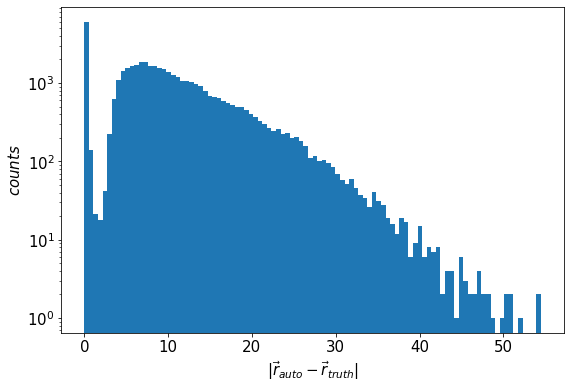

In [206]:
plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots()
ax.hist(dist_match.flatten(), 100, log=True)

ax.set_xlabel(r'$|\vec{r}_{auto} - \vec{r}_{truth}|$')
ax.set_ylabel(r'$counts$')

fig.savefig(path_figsave0+'distance_hist.png', format='png')


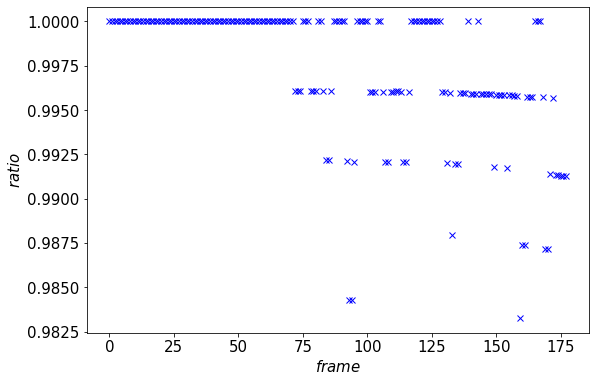

In [207]:
plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams["font.size"] = 15

flg_close = np.logical_not(np.isnan(dist_match))

flg_r = np.logical_not(np.logical_or(np.isnan(trajList['x'][:, :tmax]), np.isnan(trajList['y'][:, :tmax])))

rate_match = np.sum(flg_close, axis=0)/np.sum(flg_r, axis=0)

fig, ax = plt.subplots()
ax.plot(rate_match, 'bx')

ax.set_xlabel(r'$frame$')
ax.set_ylabel(r'$ratio$')

fig.savefig(path_figsave0+'match_rate.png', format='png')


/tmp/ipykernel_21905/315137241.py:10: RuntimeWarning: divide by zero encountered in true_divide
  dv_rate = dv_mag/v_mag


(array([8.744e+03, 6.981e+03, 6.824e+03, 5.247e+03, 3.712e+03, 2.569e+03,
        1.861e+03, 1.301e+03, 9.920e+02, 7.720e+02, 6.300e+02, 5.450e+02,
        4.430e+02, 3.630e+02, 3.830e+02, 3.050e+02, 3.010e+02, 2.310e+02,
        2.180e+02, 2.120e+02, 1.880e+02, 1.450e+02, 1.330e+02, 1.270e+02,
        9.900e+01, 1.010e+02, 8.000e+01, 6.000e+01, 5.200e+01, 3.800e+01,
        3.200e+01, 3.600e+01, 3.700e+01, 2.800e+01, 2.400e+01, 2.300e+01,
        1.500e+01, 1.200e+01, 9.000e+00, 4.000e+00, 9.000e+00, 7.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 6.000e+00, 3.000e+00, 2.000e+00,
        5.000e+00, 4.000e+00, 3.000e+00, 8.000e+00, 9.000e+00, 1.100e+01,
        1.000e+01, 6.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

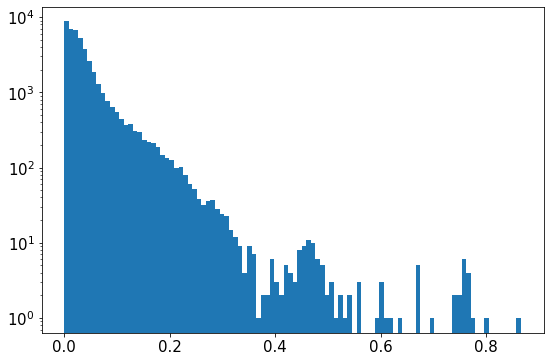

In [208]:
dvx = vx - vx_match
dvy = vy - vy_match

v_mag = (vx**2 + vy**2)**0.5
vm_mag = (vx_match**2 + vy_match**2)**0.5
dv_mag = (dvx**2 + dvy**2)**0.5

flg_mag = v_mag > 0

dv_rate = dv_mag/v_mag

plt.hist(dv_mag[flg_mag].flatten(), 100, log=True)


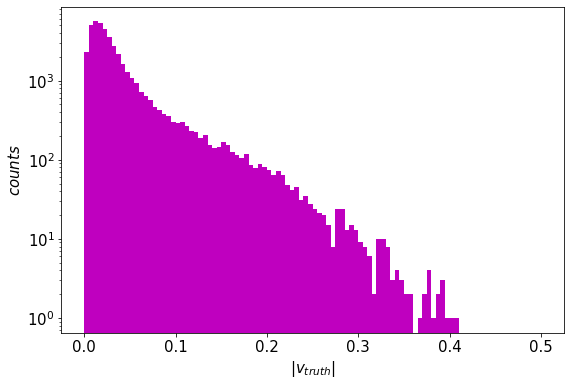

In [209]:
plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots()
ax.hist(v_mag[flg_close],100, range=[0, 0.5], color='m', log=True, label=r'$|\vec{r}_{auto} - \vec{r}_{truth}| < 5 \mu m$')
ax.hist(v_mag[np.logical_not(flg_close)], 100, range=[0, 0.5], color='b', log=True, label=r'$|\vec{r}_{auto} - \vec{r}_{truth}| > 5 \mu m$')

#ax.legend()

ax.set_xlabel(r'$|v_{truth}|$')
ax.set_ylabel(r'$counts$')

fig.savefig(path_figsave0+'speed_hist.png', format='png')


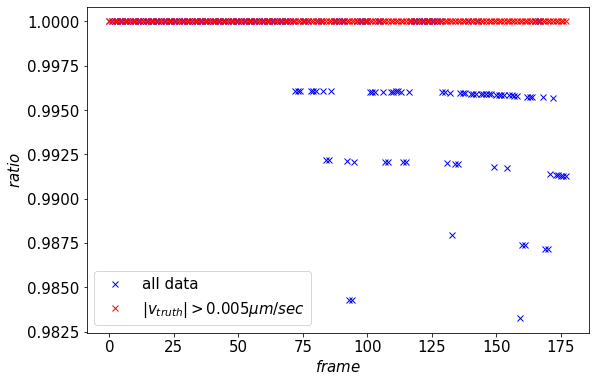

In [210]:
plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams["font.size"] = 15

flg_v_large = v_mag > 0.005

flg_close2 = np.logical_and(flg_close, flg_v_large)
flg_r2 = np.logical_and(flg_r, flg_v_large)

rate_match2 = np.sum(flg_close2, axis=0)/np.sum(flg_r2, axis=0)

fig, ax = plt.subplots()
ax.plot(rate_match, 'bx', label='all data')
ax.plot(rate_match2, 'rx', label=r'$|v_{truth}| > 0.005 \mu m/sec$')

ax.legend()

ax.set_xlabel(r'$frame$')
ax.set_ylabel(r'$ratio$')

fig.savefig(path_figsave0+'match_rate_speed.png', format='png')



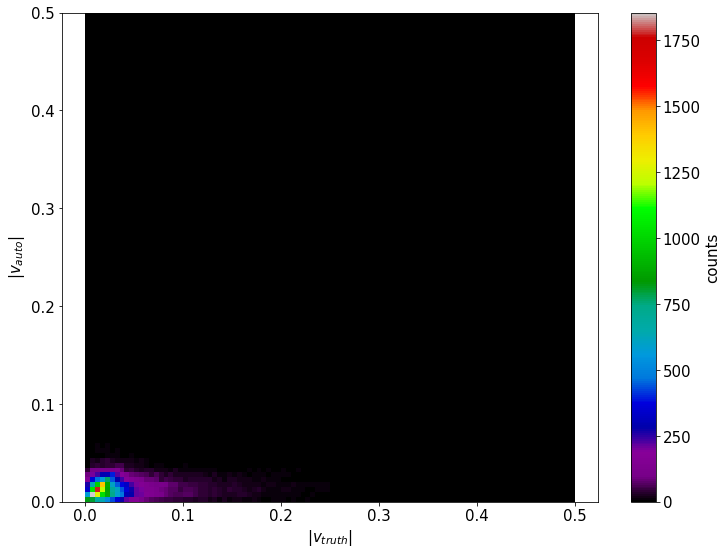

In [211]:
plt.rcParams["figure.figsize"] = [12,9]
plt.rcParams["font.size"] = 15

flg_nan = np.logical_and(np.logical_not(np.isnan(vm_mag)), flg_close)

fig, ax = plt.subplots()
h=ax.hist2d(v_mag[flg_nan].flatten(), vm_mag[flg_nan].flatten(), 100, range=[[0, 0.5], [0, 0.5]], cmap='nipy_spectral')
ax.set_xlabel(r'$|v_{truth}|$')
ax.set_ylabel(r'$|v_{auto}|$')
ax.axis('equal')
fig.colorbar(h[3], label='counts')

fig.savefig(path_figsave0+'v_VS_v.png', format='png')


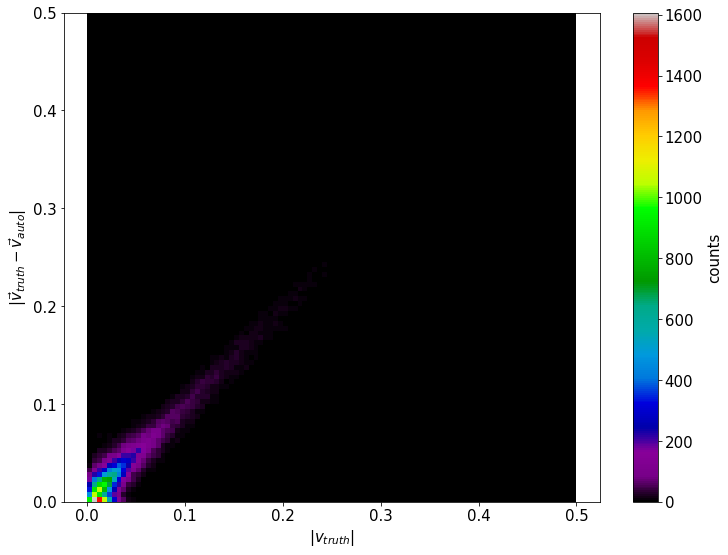

In [212]:
plt.rcParams["figure.figsize"] = [12,9]
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots()
h=ax.hist2d(v_mag[flg_nan].flatten(), dv_mag[flg_nan].flatten(), 100, range=[[0, 0.5], [0, 0.5]], cmap='nipy_spectral')
ax.set_xlabel(r'$|v_{truth}|$')
ax.set_ylabel(r'$|\vec{v}_{truth} - \vec{v}_{auto}|$')
ax.axis('equal')
fig.colorbar(h[3], label='counts')

fig.savefig(path_figsave0+'v_VS_dv.png', format='png')


(array([[1.015e+03, 3.450e+02, 1.070e+02, ..., 0.000e+00, 0.000e+00,
         1.000e+00],
        [3.545e+03, 2.810e+02, 7.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [4.397e+03, 4.700e+01, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([4.93963561e-05, 4.12667849e-03, 8.20396062e-03, 1.22812427e-02,
        1.63585249e-02, 2.04358070e-02, 2.45130891e-02, 2.85903713e-02,
        3.26676534e-02, 3.67449355e-02, 4.08222177e-02, 4.48994998e-02,
        4.89767819e-02, 5.30540641e-02, 5.71313462e-02, 6.12086283e-02,
        6.52859104e-02, 6.93631926e-02, 7.34404747e-02, 7.75177568e-02,
        8.15950390e-02, 8.56723211e-02, 8.97496032e-02, 9.38268854e-02,
        9.790

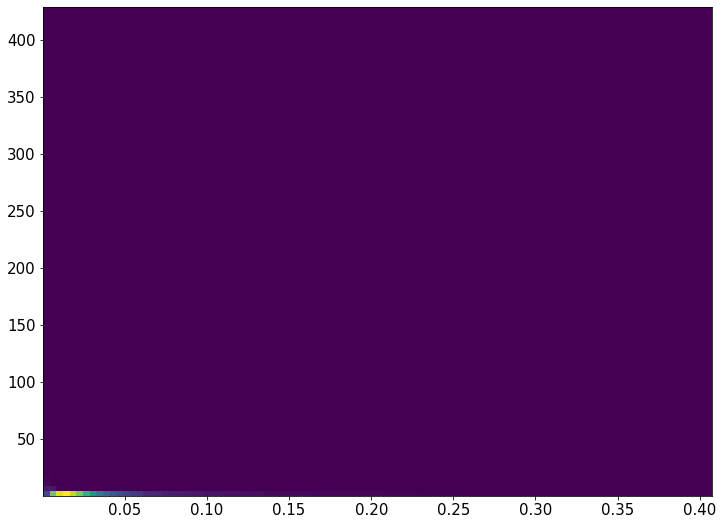

In [213]:
plt.hist2d(v_mag[flg_mag].flatten(), dv_rate[flg_mag].flatten(), 100)


In [214]:
flg_nan_all = np.logical_not(np.isnan(vm_mag))

flg_nan2 = np.logical_and(np.logical_not(np.isnan(vm_mag)), flg_v_large)
ratio_mag =  dv_mag[flg_nan2].flatten() / v_mag[flg_nan2].flatten()

ratio_mag_mean = np.nanmean(ratio_mag)
print(ratio_mag_mean)


1.1259360700556422


/tmp/ipykernel_21905/1346861441.py:5: RuntimeWarning: invalid value encountered in floor_divide
  v_bin_i = v_mag // 0.005
/tmp/ipykernel_21905/1346861441.py:15: RuntimeWarning: Mean of empty slice
  dv_mean[i] = np.nanmean(dv_mag[flg_v_bin] / v_mag[flg_v_bin])
/home/uwamichi/.pyenv/versions/3.8.13/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


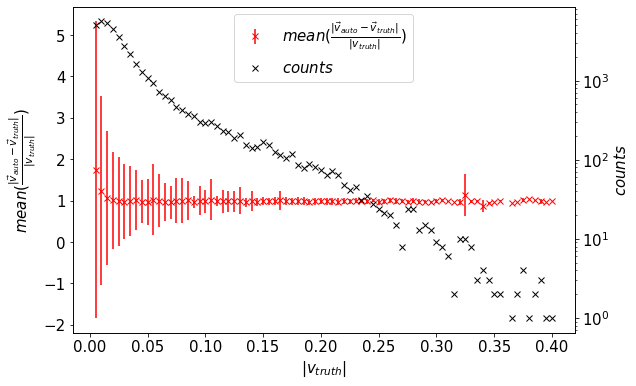

In [215]:
plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams["font.size"] = 15


v_bin_i = v_mag // 0.005

max_v_bin = int(v_bin_i[np.logical_not(np.isnan(v_bin_i))].max())

dv_mean = np.zeros((max_v_bin,))
dv_std = np.zeros((max_v_bin,))
v_bin_count = np.zeros((max_v_bin,))

for i in range(max_v_bin):
    flg_v_bin = np.logical_and(v_bin_i == i, flg_nan2)
    dv_mean[i] = np.nanmean(dv_mag[flg_v_bin] / v_mag[flg_v_bin])
    dv_std[i] = np.nanstd(dv_mag[flg_v_bin] / v_mag[flg_v_bin])
    v_bin_count[i] = np.sum(flg_v_bin)
  

fig, ax = plt.subplots()
ax.errorbar(np.arange(max_v_bin)*0.005, dv_mean, yerr=dv_std, fmt='x', color='r', label = r'$mean(\frac{|\vec{v}_{auto} - \vec{v}_{truth}|}{|v_{truth}|})$')

ax.set_xlabel(r'$|v_{truth}|$')
ax.set_ylabel(r'$mean(\frac{|\vec{v}_{auto} - \vec{v}_{truth}|}{|v_{truth}|})$')

ax2 = ax.twinx()
ax2.semilogy(np.arange(1,max_v_bin)*0.005, v_bin_count[1:], 'kx', label = r'$counts$')

#ax.set_xlabel(r'$|v_{truth}|$')
ax2.set_ylabel(r'$counts$')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='upper center')

fig.savefig(path_figsave0+'dv_ratio.png', format='png')



In [216]:
flg_v_large2 = np.logical_and(v_mag > 0.1, dv_rate > 0.4)

x_data = trajList['x'][:, :-DELAY_DIV] / xyscale
y_data = trajList['y'][:, :-DELAY_DIV] / xyscale

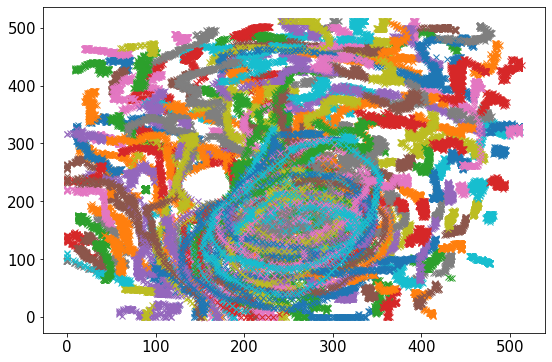

In [217]:
plt.plot(x_data.T, y_data.T, 'x')

In [218]:

plt.rcParams['figure.figsize'] = [16, 12]

files_im = os.listdir(path_im)
files_file_im = np.array([f for f in files_im if os.path.isfile(os.path.join(path_im, f))])
files_file_im = np.sort(files_file_im)
print(files_file_im)   # ['file1', 'file2.txt', 'file3.jpg']

flg_tif_im = np.array([os.path.splitext(f)[1]=='.tif' for f in files_file_im])
print(flg_tif_im)

tif_names_im = files_file_im[flg_tif_im]
print(tif_names_im)

N_frames = tif_names_im.size

cm = plt.get_cmap("jet")
n_traj_plot = 10

t_plot_range = np.arange(-n_traj_plot, DELAY_DIV+1, 1, dtype=int)

colors = cm(np.linspace(0,1,t_plot_range.size))

for t in range(N_frames - DELAY_DIV):
    im = np.zeros((512,512,3), dtype=np.float32)
    im[...,:2] = np.transpose(io.imread(os.path.join(path_im, tif_names_im[t]))/65535., (1,2,0))
    
    fig, ax = plt.subplots()
    ax.imshow(im)
    
    ax.plot(x_data[:,t][flg_v_large2[:,t]], y_data[:,t][flg_v_large2[:,t]], 'co', ms=12, mfc='none')
    
    t_plots_cand = t + t_plot_range
    flg_plots = np.logical_and(t_plots_cand >= 0, t_plots_cand < N_frames-1)
    
    t_plots = t_plots_cand[flg_plots]
    color_plots = colors[flg_plots]
    
    for i, tp in enumerate(t_plots):
        
        ax.plot(x_data[:, tp:(tp+2)][flg_v_large2[:,t]].T, y_data[:, tp:(tp+2)][flg_v_large2[:,t]].T, '-', color=color_plots[i])
    
    ax.set_xlim(-1, 513)
    ax.set_ylim(-1, 513)
    
    fig.savefig(os.path.join(path_figsave, os.path.splitext(tif_names_im[t])[0])+'.png', format='png')
    
    plt.clf()
    plt.close()



['t000.tif' 't001.tif' 't002.tif' 't003.tif' 't004.tif' 't005.tif'
 't006.tif' 't007.tif' 't008.tif' 't009.tif' 't010.tif' 't011.tif'
 't012.tif' 't013.tif' 't014.tif' 't015.tif' 't016.tif' 't017.tif'
 't018.tif' 't019.tif' 't020.tif' 't021.tif' 't022.tif' 't023.tif'
 't024.tif' 't025.tif' 't026.tif' 't027.tif' 't028.tif' 't029.tif'
 't030.tif' 't031.tif' 't032.tif' 't033.tif' 't034.tif' 't035.tif'
 't036.tif' 't037.tif' 't038.tif' 't039.tif' 't040.tif' 't041.tif'
 't042.tif' 't043.tif' 't044.tif' 't045.tif' 't046.tif' 't047.tif'
 't048.tif' 't049.tif' 't050.tif' 't051.tif' 't052.tif' 't053.tif'
 't054.tif' 't055.tif' 't056.tif' 't057.tif' 't058.tif' 't059.tif'
 't060.tif' 't061.tif' 't062.tif' 't063.tif' 't064.tif' 't065.tif'
 't066.tif' 't067.tif' 't068.tif' 't069.tif' 't070.tif' 't071.tif'
 't072.tif' 't073.tif' 't074.tif' 't075.tif' 't076.tif' 't077.tif'
 't078.tif' 't079.tif' 't080.tif' 't081.tif' 't082.tif' 't083.tif'
 't084.tif' 't085.tif' 't086.tif' 't087.tif' 't088.tif' 't089.

In [219]:
x_match_plot = x_match / xyscale
y_match_plot = y_match / xyscale

In [220]:
cm = plt.get_cmap("jet")
n_traj_plot = 10

t_plot_range = np.arange(-n_traj_plot, DELAY_DIV+1, 1, dtype=int)

colors = cm(np.linspace(0,1,t_plot_range.size))

for t in range(N_frames - DELAY_DIV):
    im = np.zeros((512,512,3), dtype=np.float32)
    im[...,:2] = np.transpose(io.imread(os.path.join(path_im, tif_names_im[t]))/65535., (1,2,0))
    
    fig, ax = plt.subplots()
    ax.imshow(im)
    
    ax.plot(x_match_plot[:,t][flg_v_large2[:,t]], y_match_plot[:,t][flg_v_large2[:,t]], 'co', ms=12, mfc='none')
    
    t_plots_cand = t + t_plot_range
    flg_plots = np.logical_and(t_plots_cand >= 0, t_plots_cand < N_frames-1)
    
    t_plots = t_plots_cand[flg_plots]
    color_plots = colors[flg_plots]
    
    for i, tp in enumerate(t_plots):
        
        ax.plot(x_match_plot[:, tp:(tp+2)][flg_v_large2[:,t]].T, y_match_plot[:, tp:(tp+2)][flg_v_large2[:,t]].T, '-', color=color_plots[i])
    
    ax.set_xlim(-1, 513)
    ax.set_ylim(-1, 513)
    
    fig.savefig(os.path.join(path_figsave2, os.path.splitext(tif_names_im[t])[0])+'.png', format='png')
    
    plt.clf()
    plt.close()


In [221]:
np.savetxt(path_figsave0+'x.csv', trajList['x'], delimiter=',')
np.savetxt(path_figsave0+'y.csv', trajList['y'], delimiter=',')
np.savetxt(path_figsave0+'dv_ratio.csv', [ratio_mag_mean], delimiter=',')

In [222]:
print(trajList['x'])

[[ 9.69478 10.42049 10.36405 ... 15.37291 15.74553 15.49691]
 [89.91881 89.94096 89.63576 ... 50.78223 50.40931 50.14328]
 [98.098   97.9794  98.1329  ... 83.77821 82.94775 82.91376]
 ...
 [74.66474 75.67235 74.61768 ... 73.35471 73.66973 73.92839]
 [90.58835 90.13635 90.28702 ... 92.10343 92.36454 91.87424]
 [     nan      nan      nan ... 79.80914 79.77887 79.55318]]
